# Data Engineers' Challenge #6: The Dollar Auction

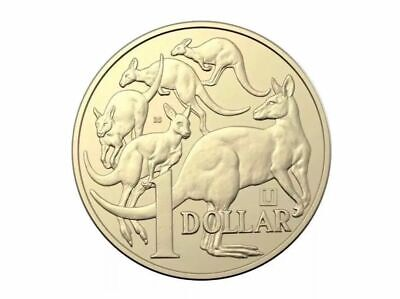

In [7]:
import pandas as pd
import time

In [8]:
# Player strategies
def christies_strategy(num_players, bid_history, money):
    import random
    # Determine the valuation of the coin. This will change over the course of the game.
    coin_value = random.randint(5, 15) / 20

    current_bid = bid_history.iloc[-1]["bid"]

    # Aggressive opening bid if no bid has been placed .
    if current_bid == 0.0:
        bid = 0.10
        return bid if bid <= money else False

    # Filter only valid moves (where the bid actually changed)
    valid_moves = bid_history[bid_history['bid'].diff() != 0].reset_index(drop=True)

    # If Christie's was the second last bidder (i.e. currently in second place), then bid to reclaim leadership.
    if len(valid_moves) >= 2:
        second_last_move = valid_moves.iloc[-2]
        if second_last_move["player"] == "Christies":
            bid = current_bid + 0.05
            return bid if bid <= money and bid < 0.75 else False

    # When bids are low, exhibit aggressive behavior with a larger jump.
    if current_bid < 0.4:
        bid = current_bid + 0.10
        return bid if bid <= money else False

    # For higher bids, use a minimal increment to preserve profitability.
    bid = current_bid + 0.05
    return bid if bid <= money and bid < coin_value else False

def ANDII_function_will_do(num_players, bid_history, money):
    try:
        current_bid = bid_history.iloc[-1]['bid']
    except IndexError:
        return 0.05
    else:
        if current_bid < money and current_bid < 0.95:
            return current_bid + 0.2
        else:
            return False

def reckless_ryan(num_players, bid_history, money):
    # First to bid, bid
    if bid_history.empty or len(bid_history) == 0:
        return 0.05

    current_bid = bid_history.iloc[-1]["bid"]

    # No money, no bid
    if current_bid + 0.05 > money:
        return False

    # Always bid if current bid < 0.8
    if current_bid < 0.8:
        return current_bid + 0.05

    # Determine valid moves by looking only at rows where the bid increased
    valid_moves = bid_history[bid_history['bid'].diff() != 0].reset_index(drop=True)

    # Check if there are at least two valid moves. The last valid move represents the current highest bidder,
    # and the second-to-last valid move is the current second highest bidder.
    if len(valid_moves) >= 2:
        second_last_move = valid_moves.iloc[-2]
        # Always bid if reckless_ryan is currently in second place
        if second_last_move["player"] == "reckless ryan":
            return current_bid + 0.05

    # If none of the conditions are met, do not bid.
    return False

def big_short(num_players,bid_history,money):
  current_bid = bid_history.iloc[-1]['bid']
  if current_bid / money > 0.5 or current_bid > 1:
    return False
  else:
    return current_bid + 0.05

def send_it(num_players, bid_history, money):
    current_bid = bid_history.iloc[-1]['bid']

    # Go straight to 80c, no messing around
    if current_bid < 0.8:
        if money >= 0.8:
            return 0.8
        elif money > current_bid:
            return money
        else:
            return False

    # Play the game between 80c and $1
    elif current_bid < 1.00:
        if money >= current_bid + 0.05:
            return current_bid + 0.05
        else:
            return False

    # Get out if it gets too high
    else:
        return False

def not_a_morning_strategy(n, hist, m):
    global amsleep
    if not 'amsleep' in globals():
        amsleep = 0
        return False
    if len(hist.columns) <= n:
        amsleep += 1
    if amsleep <= 3:
        return False
    current_bid = hist.iloc[-1]['bid']
    my_bid = hist.iloc[-n+1]['bid'] if len(hist.index) > n else 0
    if current_bid - my_bid < 1 and current_bid < m:
        return current_bid + 0.05
    else:
        return False

def low_risk(num_players, bid_history, money):
    current_bid = bid_history.iloc[-1]['bid']
    if current_bid < 0.25:
        return current_bid + 0.05
    else:
        return False

def super_duper_strategy(num_players, bid_history, money):
    current_bid=bid_history.iloc[-1]['bid']
    if bid_history.iloc[-1]['bid']==0 and money>=1:
        return 1.0
    elif current_bid<=0.6 and money>=current_bid+0.05:
        return current_bid+0.05
    else:
        return False

def sixbids_none_the_richer(num_players, bid_history, money):

    """
    Attempts to encourage a bidding war by bidding if there are at least 4 active bidders.
    Will attempt to buy under an arbitrary amount of money.
    """
    max_spend = 0.5
    current_bid = bid_history.iloc[-1]['bid']

    # Calculate if there are at least 4 active bidders
    def count_active_bidders(bid_history):
        active_bidders = set()
        for i in range(len(bid_history) - 1, 0, -1):
            current_bid = bid_history.iloc[i]['bid']
            previous_bid = bid_history.iloc[i - 1]['bid']
            if current_bid > previous_bid:
                player = bid_history.iloc[i]['player']
                if player not in active_bidders:
                    active_bidders.add(player)
                if len(active_bidders) >= 4:
                    return True
        return False

    # Check conditions and attempt legal bid
    if (count_active_bidders(bid_history) or current_bid < max_spend) and current_bid < money and current_bid < 1:
        return round(current_bid + 0.05, 2)
    else:
        return False

In [3]:
def run_single_auction(player_list, sleep):
    # Convert player names to full player objects and initialize scores if needed
    for name in player_list:
        if name not in total_scores:
            total_scores[name] = 2

    num_players = len(player_list)
    game_scores = [0] * num_players
    highest_bidder = None
    highest_bid = 0
    second_highest_bidder = None
    second_highest_bid = 0

    print(f"\nStarting Dollar Auction with players: {', '.join(player_list)}\n")

    current_player = 0
    passes = 0  # Count of consecutive passes (no bids)

    while True:
        time.sleep(sleep)
        # Skip the current highest bidder if they exist
        if highest_bidder is not None and current_player == highest_bidder:
            current_player = (current_player + 1) % num_players
            continue
        player = player_list[current_player]
        current_bid = highest_bid
        # Initialize bid_history if this is the first bid
        if 'bid_history' not in locals():
            bid_history = pd.DataFrame({'player': ['Start'], 'bid': [current_bid]})

        money = round(total_scores[player],2)
        emoji = players[player]['emoji']
        bid = players[player]['strategy'](num_players, bid_history, money)
        bid = round(bid, 2) if bid is not False else bid


        # Process bid
        if bid is False:
            print(f"{emoji} {player} does not bid.")
            passes += 1
        elif isinstance(bid, float):
            # Check that bid is higher than the current bid, is a multiple of 0.05, and is less than or equal to the players money
            if bid > current_bid and abs(round(bid * 100) % 5) == 0 and bid <= money:
                print(f"{emoji} {player} bids ${bid:.2f}")
                # Update second highest bidder and bid
                second_highest_bidder = highest_bidder
                second_highest_bid = highest_bid
                # Update highest bidder and bid
                highest_bidder = current_player
                highest_bid = bid
                passes = 0  # Reset passes counter on valid bid

            else:
                if bid <= current_bid:
                    print(f'{emoji} {player} attempted invalid bid of ${bid:.2f} (must be > ${current_bid:.2f} and multiple of $0.05).')
                elif abs(bid * 100 % 5) >= 1e-9:
                    print(abs(bid * 100 % 5))
                    print(f'{emoji} {player} attempted invalid bid of ${bid:.2f}. The bid must be a multiple of 5c!')
                elif  bid > money:
                    print(f'{emoji} {player} attempted invalid bid of ${bid:.2f}. Insufficient funds!')
                passes += 1
                highest_bid = current_bid
        else:
            print(f'{emoji} {player} returned invalid bid type. Bid rejected.')
            passes += 1
            highest_bid = current_bid

        if 'bid_history' in locals():
            bid_history = pd.concat([bid_history, pd.DataFrame({'player': [player], 'bid': [highest_bid]})], ignore_index=True)


        # Calculate number of eligible players (all except current highest bidder)
        eligible_players = num_players - (1 if highest_bidder is not None else 0)
        # End auction if passes reach the number of eligible players
        if passes >= eligible_players:
            time.sleep(sleep)
            print("\nGoing... going... GONE!")
            time.sleep(sleep)
            break

        # Move to next player (loop around)
        current_player = (current_player + 1) % num_players

    # Calculate scores after auction ends
    print("\n--- Auction Results ---")
# Update both game scores and total scores
    if highest_bid >= 0.05:
        winner = player_list[highest_bidder]
        emoji = players[winner]['emoji']

        print(f"Winner (Highest Bidder): {emoji} {winner} with a bid of ${highest_bid/1:.2f}")
        if second_highest_bidder is not None and second_highest_bid >= 0.05:
            runner_up = player_list[second_highest_bidder]
            emoji = players[runner_up]['emoji']
            print(f"Runner-up (Second Highest Bidder): {emoji} {runner_up} with a bid of ${second_highest_bid/1:.2f}")
        else:
            print("Runner-up: No valid second bidder")

        # Update game scores and total scores
        game_scores[highest_bidder] += 1 - highest_bid
        total_scores[player_list[highest_bidder]] += 1.00 - highest_bid

        if second_highest_bidder is not None:
            game_scores[second_highest_bidder] -= second_highest_bid
            total_scores[player_list[second_highest_bidder]] -= second_highest_bid
    else:
        print("No valid bids were placed. The dollar is not awarded.")

    # Print game results
    print("\nGame Scores:")
    for player, score in zip(player_list, game_scores):
        print(f"{player}: ${score/1:z.2f}")

    print("\nCumulative Scores:")
    sorted_total_scores = sorted(
        total_scores.items(),
        key=lambda x: (-x[1], x[0])
    )
    for name, score in sorted_total_scores:
        print(f"{name}: ${score/1:z.2f}")

    print("\n" + "="*50)


def print_final_scores():
    print("\n=== Final Accumulated Scores ===")
    sorted_final_scores = sorted(
        total_scores.items(),
        key=lambda x: (-x[1], x[0])
    )
    for name, score in sorted_final_scores:
        print(f"{name}: ${score/1:z.2f}")

def generate_matchups(players_per_matchup):
    """
    Generate random matchups from the global players dictionary with variable group sizes.

    Parameters:
        players_per_matchup (list[int]): List of integers specifying how many players should be in each matchup.
                                        Sum must equal total number of players.

    Returns:
        List of matchups, where each matchup is a list of player names.

    Raises:
        ValueError: if the sum of players_per_matchup doesn't equal the total number of players.
    """
    import random

    player_names = list(players.keys())
    total_players = len(player_names)
    required_players = sum(players_per_matchup)

    if total_players != required_players:
        raise ValueError(
            f"Sum of players per matchup ({required_players}) "
            f"does not equal total number of players ({total_players})."
        )

    random.shuffle(player_names)

    matchups = []
    start_idx = 0

    # Create matchups of specified sizes from the shuffled player list
    for group_size in players_per_matchup:
        matchup = player_names[start_idx:start_idx + group_size]
        matchups.append(matchup)
        start_idx += group_size

    # Print formatted matchups
    for idx, matchup in enumerate(matchups):
        formatted_players = "', '".join(matchup)
        print(f"Matchup {idx + 1}: ['{formatted_players}']")

    return matchups




In [9]:
# Define all available players
players = {
    'Christies': {'strategy': christies_strategy, 'emoji': '©️'},
    'ASR': {'strategy': ANDII_function_will_do, 'emoji': '🤞'},
    'Big Short': {'strategy': big_short, 'emoji': '🤑'},
    'reckless ryan': {'strategy': reckless_ryan, 'emoji': '🥺'},
    'Send it': {'strategy': send_it, 'emoji': '🚀'},
    'Edan': {'strategy': not_a_morning_strategy, 'emoji': '😴'},
    'aymon': {'strategy': low_risk, 'emoji': '😨'},
    'Super Duper': {'strategy': super_duper_strategy, 'emoji': '🌻'},
    'Sixbids': {'strategy': sixbids_none_the_richer, 'emoji': '6️⃣'}
}

# Global dictionary to track total scores
total_scores = {}


In [10]:
print('First round matchups')
matchups = generate_matchups([3, 3, 3])

First round matchups
Matchup 1: ['Christies', 'Send it', 'Super Duper']
Matchup 2: ['Big Short', 'Edan', 'aymon']
Matchup 3: ['reckless ryan', 'Sixbids', 'ASR']


In [11]:
# Run first round auctions
run_single_auction(['Christies', 'Send it', 'Super Duper'], 2)


Starting Dollar Auction with players: Christies, Send it, Super Duper

©️ Christies bids $0.10
🚀 Send it bids $0.80
🌻 Super Duper does not bid.
©️ Christies does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🚀 Send it with a bid of $0.80
Runner-up (Second Highest Bidder): ©️ Christies with a bid of $0.10

Game Scores:
Christies: $-0.10
Send it: $0.20
Super Duper: $0.00

Cumulative Scores:
Send it: $2.20
Super Duper: $2.00
Christies: $1.90



In [12]:
run_single_auction(['Big Short', 'Edan', 'aymon'], 2)


Starting Dollar Auction with players: Big Short, Edan, aymon

🤑 Big Short bids $0.05
😴 Edan does not bid.
😨 aymon bids $0.10
🤑 Big Short bids $0.15
😴 Edan does not bid.
😨 aymon bids $0.20
🤑 Big Short bids $0.25
😴 Edan does not bid.
😨 aymon does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🤑 Big Short with a bid of $0.25
Runner-up (Second Highest Bidder): 😨 aymon with a bid of $0.20

Game Scores:
Big Short: $0.75
Edan: $0.00
aymon: $-0.20

Cumulative Scores:
Big Short: $2.75
Send it: $2.20
Edan: $2.00
Super Duper: $2.00
Christies: $1.90
aymon: $1.80



In [13]:
run_single_auction(['reckless ryan', 'Sixbids', 'ASR'], 2)


Starting Dollar Auction with players: reckless ryan, Sixbids, ASR

🥺 reckless ryan bids $0.05
6️⃣ Sixbids bids $0.10
🤞 ASR bids $0.30
🥺 reckless ryan bids $0.35
6️⃣ Sixbids bids $0.40
🤞 ASR bids $0.60
🥺 reckless ryan bids $0.65
6️⃣ Sixbids does not bid.
🤞 ASR bids $0.85
🥺 reckless ryan bids $0.90
6️⃣ Sixbids does not bid.
🤞 ASR bids $1.10
🥺 reckless ryan bids $1.15
6️⃣ Sixbids does not bid.
🤞 ASR does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🥺 reckless ryan with a bid of $1.15
Runner-up (Second Highest Bidder): 🤞 ASR with a bid of $1.10

Game Scores:
reckless ryan: $-0.15
Sixbids: $0.00
ASR: $-1.10

Cumulative Scores:
Big Short: $2.75
Send it: $2.20
Edan: $2.00
Sixbids: $2.00
Super Duper: $2.00
Christies: $1.90
reckless ryan: $1.85
aymon: $1.80
ASR: $0.90



In [14]:
print('Second round matchups')
matchups = generate_matchups([3, 3, 3])

Second round matchups
Matchup 1: ['ASR', 'Super Duper', 'Send it']
Matchup 2: ['Sixbids', 'Christies', 'Edan']
Matchup 3: ['reckless ryan', 'aymon', 'Big Short']


In [15]:
# Run second round auctions
run_single_auction(['ASR', 'Super Duper', 'Send it'], 2)


Starting Dollar Auction with players: ASR, Super Duper, Send it

🤞 ASR bids $0.20
🌻 Super Duper bids $0.25
🚀 Send it bids $0.80
🤞 ASR attempted invalid bid of $1.00. Insufficient funds!
🌻 Super Duper does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🚀 Send it with a bid of $0.80
Runner-up (Second Highest Bidder): 🌻 Super Duper with a bid of $0.25

Game Scores:
ASR: $0.00
Super Duper: $-0.25
Send it: $0.20

Cumulative Scores:
Big Short: $2.75
Send it: $2.40
Edan: $2.00
Sixbids: $2.00
Christies: $1.90
reckless ryan: $1.85
aymon: $1.80
Super Duper: $1.75
ASR: $0.90



In [16]:
run_single_auction(['Sixbids', 'Christies', 'Edan'], 2)


Starting Dollar Auction with players: Sixbids, Christies, Edan

6️⃣ Sixbids bids $0.05
©️ Christies bids $0.15
😴 Edan does not bid.
6️⃣ Sixbids bids $0.20
©️ Christies bids $0.25
😴 Edan bids $0.30
6️⃣ Sixbids bids $0.35
©️ Christies bids $0.45
😴 Edan bids $0.50
6️⃣ Sixbids does not bid.
©️ Christies bids $0.55
😴 Edan bids $0.60
6️⃣ Sixbids does not bid.
©️ Christies bids $0.65
😴 Edan bids $0.70
6️⃣ Sixbids does not bid.
©️ Christies does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 😴 Edan with a bid of $0.70
Runner-up (Second Highest Bidder): ©️ Christies with a bid of $0.65

Game Scores:
Sixbids: $0.00
Christies: $-0.65
Edan: $0.30

Cumulative Scores:
Big Short: $2.75
Send it: $2.40
Edan: $2.30
Sixbids: $2.00
reckless ryan: $1.85
aymon: $1.80
Super Duper: $1.75
Christies: $1.25
ASR: $0.90



In [17]:
run_single_auction(['reckless ryan', 'aymon', 'Big Short'], 2)


Starting Dollar Auction with players: reckless ryan, aymon, Big Short

🥺 reckless ryan bids $0.05
😨 aymon bids $0.10
🤑 Big Short bids $0.15
🥺 reckless ryan bids $0.20
😨 aymon bids $0.25
🤑 Big Short bids $0.30
🥺 reckless ryan bids $0.35
😨 aymon does not bid.
🤑 Big Short bids $0.40
🥺 reckless ryan bids $0.45
😨 aymon does not bid.
🤑 Big Short bids $0.50
🥺 reckless ryan bids $0.55
😨 aymon does not bid.
🤑 Big Short bids $0.60
🥺 reckless ryan bids $0.65
😨 aymon does not bid.
🤑 Big Short bids $0.70
🥺 reckless ryan bids $0.75
😨 aymon does not bid.
🤑 Big Short bids $0.80
🥺 reckless ryan bids $0.85
😨 aymon does not bid.
🤑 Big Short bids $0.90
🥺 reckless ryan bids $0.95
😨 aymon does not bid.
🤑 Big Short bids $1.00
🥺 reckless ryan bids $1.05
😨 aymon does not bid.
🤑 Big Short does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🥺 reckless ryan with a bid of $1.05
Runner-up (Second Highest Bidder): 🤑 Big Short with a bid of $1.00

Game Scores:
reckless ryan: $-0.

In [18]:
print('Third round matchups')
matchups = generate_matchups([4, 5])

Third round matchups
Matchup 1: ['Super Duper', 'aymon', 'Sixbids', 'Christies']
Matchup 2: ['Send it', 'ASR', 'reckless ryan', 'Big Short', 'Edan']


In [19]:
# Run first round auctions
run_single_auction(['Super Duper', 'aymon', 'Sixbids', 'Christies'], 1)


Starting Dollar Auction with players: Super Duper, aymon, Sixbids, Christies

🌻 Super Duper bids $1.00
😨 aymon does not bid.
6️⃣ Sixbids does not bid.
©️ Christies does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🌻 Super Duper with a bid of $1.00
Runner-up: No valid second bidder

Game Scores:
Super Duper: $0.00
aymon: $0.00
Sixbids: $0.00
Christies: $0.00

Cumulative Scores:
Send it: $2.40
Edan: $2.30
Sixbids: $2.00
aymon: $1.80
reckless ryan: $1.80
Big Short: $1.75
Super Duper: $1.75
Christies: $1.25
ASR: $0.90



In [20]:
run_single_auction(['Send it', 'ASR', 'reckless ryan', 'Big Short', 'Edan'], 2)


Starting Dollar Auction with players: Send it, ASR, reckless ryan, Big Short, Edan

🚀 Send it bids $0.80
🤞 ASR attempted invalid bid of $1.00. Insufficient funds!
🥺 reckless ryan does not bid.
🤑 Big Short bids $0.85
😴 Edan bids $0.90
🚀 Send it bids $0.95
🤞 ASR does not bid.
🥺 reckless ryan does not bid.
🤑 Big Short does not bid.
😴 Edan bids $1.00
🚀 Send it does not bid.
🤞 ASR does not bid.
🥺 reckless ryan does not bid.
🤑 Big Short does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 😴 Edan with a bid of $1.00
Runner-up (Second Highest Bidder): 🚀 Send it with a bid of $0.95

Game Scores:
Send it: $-0.95
ASR: $0.00
reckless ryan: $0.00
Big Short: $0.00
Edan: $0.00

Cumulative Scores:
Edan: $2.30
Sixbids: $2.00
aymon: $1.80
reckless ryan: $1.80
Big Short: $1.75
Super Duper: $1.75
Send it: $1.45
Christies: $1.25
ASR: $0.90



In [21]:
print('Fourth round matchups')
matchups = generate_matchups([4, 5])

Fourth round matchups
Matchup 1: ['Edan', 'Big Short', 'aymon', 'Christies']
Matchup 2: ['Super Duper', 'Sixbids', 'reckless ryan', 'Send it', 'ASR']


In [22]:
# Run fourth round auctions
run_single_auction(['Edan', 'Big Short', 'aymon', 'Christies'], 2)


Starting Dollar Auction with players: Edan, Big Short, aymon, Christies

😴 Edan bids $0.05
🤑 Big Short bids $0.10
😨 aymon bids $0.15
©️ Christies bids $0.25
😴 Edan bids $0.30
🤑 Big Short bids $0.35
😨 aymon does not bid.
©️ Christies bids $0.45
😴 Edan bids $0.50
🤑 Big Short bids $0.55
😨 aymon does not bid.
©️ Christies does not bid.
😴 Edan bids $0.60
🤑 Big Short bids $0.65
😨 aymon does not bid.
©️ Christies does not bid.
😴 Edan bids $0.70
🤑 Big Short bids $0.75
😨 aymon does not bid.
©️ Christies does not bid.
😴 Edan bids $0.80
🤑 Big Short bids $0.85
😨 aymon does not bid.
©️ Christies does not bid.
😴 Edan bids $0.90
🤑 Big Short does not bid.
😨 aymon does not bid.
©️ Christies does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 😴 Edan with a bid of $0.90
Runner-up (Second Highest Bidder): 🤑 Big Short with a bid of $0.85

Game Scores:
Edan: $0.10
Big Short: $-0.85
aymon: $0.00
Christies: $0.00

Cumulative Scores:
Edan: $2.40
Sixbids: $2.00
aymon: $1.80

In [23]:
run_single_auction(['Super Duper', 'Sixbids', 'reckless ryan', 'Send it', 'ASR'], 1)


Starting Dollar Auction with players: Super Duper, Sixbids, reckless ryan, Send it, ASR

🌻 Super Duper bids $1.00
6️⃣ Sixbids does not bid.
🥺 reckless ryan does not bid.
🚀 Send it does not bid.
🤞 ASR does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 🌻 Super Duper with a bid of $1.00
Runner-up: No valid second bidder

Game Scores:
Super Duper: $0.00
Sixbids: $0.00
reckless ryan: $0.00
Send it: $0.00
ASR: $0.00

Cumulative Scores:
Edan: $2.40
Sixbids: $2.00
aymon: $1.80
reckless ryan: $1.80
Super Duper: $1.75
Send it: $1.45
Christies: $1.25
Big Short: $0.90
ASR: $0.90



In [24]:
print('Final round matchups')
matchups = generate_matchups([9])

Final round matchups
Matchup 1: ['ASR', 'Send it', 'Super Duper', 'Edan', 'reckless ryan', 'Christies', 'aymon', 'Big Short', 'Sixbids']


In [25]:
run_single_auction(['ASR', 'Send it', 'Super Duper', 'Edan', 'reckless ryan', 'Christies', 'aymon', 'Big Short', 'Sixbids'], 3)



Starting Dollar Auction with players: ASR, Send it, Super Duper, Edan, reckless ryan, Christies, aymon, Big Short, Sixbids

🤞 ASR bids $0.20
🚀 Send it bids $0.80
🌻 Super Duper does not bid.
😴 Edan bids $0.85
🥺 reckless ryan does not bid.
©️ Christies does not bid.
😨 aymon does not bid.
🤑 Big Short does not bid.
6️⃣ Sixbids does not bid.
🤞 ASR attempted invalid bid of $1.05. Insufficient funds!
🚀 Send it bids $0.90
🌻 Super Duper does not bid.
😴 Edan bids $0.95
🥺 reckless ryan does not bid.
©️ Christies does not bid.
😨 aymon does not bid.
🤑 Big Short does not bid.
6️⃣ Sixbids does not bid.
🤞 ASR does not bid.
🚀 Send it bids $1.00
🌻 Super Duper does not bid.
😴 Edan bids $1.05
🥺 reckless ryan does not bid.
©️ Christies does not bid.
😨 aymon does not bid.
🤑 Big Short does not bid.
6️⃣ Sixbids does not bid.
🤞 ASR does not bid.
🚀 Send it does not bid.
🌻 Super Duper does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): 😴 Edan with a bid of $1.05
Runner-up (S

In [26]:
# Print final accumulated scores
print_final_scores()


=== Final Accumulated Scores ===
Edan: $2.35
Sixbids: $2.00
aymon: $1.80
reckless ryan: $1.80
Super Duper: $1.75
Christies: $1.25
Big Short: $0.90
ASR: $0.90
Send it: $0.45
